# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 0.

In [142]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:04:56.382150
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [143]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [144]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [145]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [146]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=0
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Data Load

In [147]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [148]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:04:59.617450
Load RCI values...
Num RCI: 10338
Example RCI: [('ENSG00000000003', 1.08068), ('ENSG00000000419', 1.32679), ('ENSG00000000457', 0.434284)]
Load genes...
2022-12-29 16:04:59.645042
Load sequence...
2022-12-29 16:05:08.874150
Num IDs: 5579
Example IDs: [('ENSG00000197530', 'ENST00000518681.6'), ('ENSG00000131697', 'ENST00000622020.4'), ('ENSG00000171680', 'ENST00000377728.8'), ('ENSG00000171621', 'ENST00000328089.11')]
Count 2466 ones out of 5579 labels.
Example labels: [0, 0, 0, 1]
Num counts: 5579
Example sequence: [34, 135, 26, 102, 150, 85, 83, 74, 40, 158, 119, 219, 106, 166, 151, 90, 102, 151, 91, 107, 169, 162, 134, 22, 85, 83, 75, 43, 170, 165, 148, 79, 59, 233, 164, 143, 59, 233, 163, 138, 38, 150, 86, 87, 89, 99, 139, 42, 167, 155, 108, 175, 187, 235, 169, 163, 138, 40, 158, 118, 214, 85, 83, 76, 48, 190, 248, 222, 117, 212, 78, 54, 216, 95, 122, 230, 150, 88, 95, 123, 236, 174, 182, 215, 91, 106, 167, 156, 110, 184, 224, 126, 248, 223, 123, 233, 163,

## Model

In [149]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [150]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:05:09.071781
COMPILE
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, 3997, 4)           1028      
                                                                 
 conv1d_73 (Conv1D)          (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_60  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_145 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [151]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:05:09.189980
2022-12-29 16:05:09.190549
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (4473, 3997) (4473, 1)
Valid sizes (1106, 3997) (1106, 1)
Train set ones/size 1980 / 4473
Valid set ones/size 486 / 1106
BUILD MODEL
COMPILE
FIT
2022-12-29 16:05:10.618521
Epoch 1/5
140/140 [==============================] - 2s 9ms/step - loss: 0.6007 - accuracy: 0.6613 - val_loss: 0.5284 - val_accuracy: 0.7360
Epoch 2/5
140/140 [==============================] - 1s 7ms/step - loss: 0.5128 - accuracy: 0.7483 - val_loss: 0.5277 - val_accuracy: 0.7360
Epoch 3/5
140/140 [==============================] - 1s 7ms/step - loss: 0.5094 - accuracy: 0.7498 - val_loss: 0.5268 - val_accuracy: 0.7351
Epoch 4/5
140/140 [==============================] - 1s 7ms/step - loss: 0.5067 - accuracy: 0.7510 - val_loss: 0.5227 - val_accuracy: 0.7387
Epoch 5/5
140/140 [==============================] - 1s 7ms/step - loss: 0.5032 - accuracy: 0.7514 - val_loss: 0.5210 - val_accuracy: 

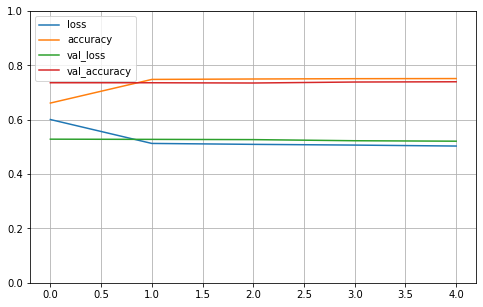

Compute valiation accuracy
2022-12-29 16:05:16.736450
Range of scores: 0.020269917 to 0.9248065
Predicted zeros and ones 666 440
Accuracy: 73.96% Precision: 72.50% Recall: 65.64% F1: 68.90%
2022-12-29 16:05:16.932161
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (4432, 3997) (4432, 1)
Valid sizes (1147, 3997) (1147, 1)
Train set ones/size 1940 / 4432
Valid set ones/size 526 / 1147
BUILD MODEL
COMPILE
FIT
2022-12-29 16:05:18.314871
Epoch 1/5
139/139 [==============================] - 2s 9ms/step - loss: 0.5983 - accuracy: 0.6516 - val_loss: 0.5128 - val_accuracy: 0.7384
Epoch 2/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5160 - accuracy: 0.7475 - val_loss: 0.5114 - val_accuracy: 0.7498
Epoch 3/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5108 - accuracy: 0.7491 - val_loss: 0.5094 - val_accuracy: 0.7402
Epoch 4/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5102 - accuracy: 0.7516 - val_loss: 0.5072 - va

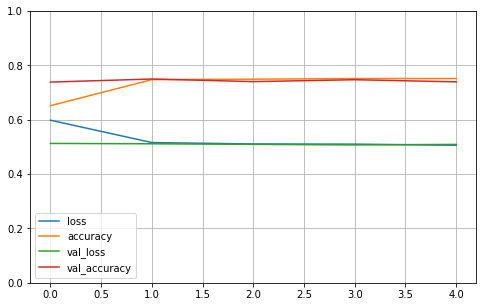

Compute valiation accuracy
2022-12-29 16:05:24.386029
Range of scores: 0.018744452 to 0.9513192
Predicted zeros and ones 622 525
Accuracy: 73.93% Precision: 71.62% Recall: 71.48% F1: 71.55%
2022-12-29 16:05:24.964453
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (4398, 3997) (4398, 1)
Valid sizes (1181, 3997) (1181, 1)
Train set ones/size 1976 / 4398
Valid set ones/size 490 / 1181
BUILD MODEL
COMPILE
FIT
2022-12-29 16:05:26.325043
Epoch 1/5
138/138 [==============================] - 2s 9ms/step - loss: 0.5958 - accuracy: 0.6676 - val_loss: 0.5233 - val_accuracy: 0.7409
Epoch 2/5
138/138 [==============================] - 1s 7ms/step - loss: 0.5110 - accuracy: 0.7494 - val_loss: 0.5223 - val_accuracy: 0.7350
Epoch 3/5
138/138 [==============================] - 1s 7ms/step - loss: 0.5059 - accuracy: 0.7526 - val_loss: 0.5223 - val_accuracy: 0.7350
Epoch 4/5
138/138 [==============================] - 1s 7ms/step - loss: 0.5038 - accuracy: 0.7538 - val_loss: 0.5227 - va

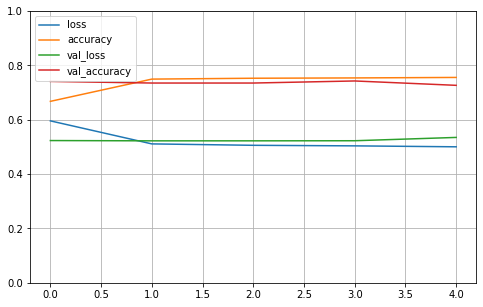

Compute valiation accuracy
2022-12-29 16:05:37.352265
Range of scores: 0.033917997 to 0.96763045
Predicted zeros and ones 616 565
Accuracy: 72.65% Precision: 64.78% Recall: 74.69% F1: 69.38%
2022-12-29 16:05:37.582445
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (4517, 3997) (4517, 1)
Valid sizes (1062, 3997) (1062, 1)
Train set ones/size 1988 / 4517
Valid set ones/size 478 / 1062
BUILD MODEL
COMPILE
FIT
2022-12-29 16:05:38.925177
Epoch 1/5
142/142 [==============================] - 2s 9ms/step - loss: 0.6038 - accuracy: 0.6571 - val_loss: 0.5082 - val_accuracy: 0.7505
Epoch 2/5
142/142 [==============================] - 1s 7ms/step - loss: 0.5157 - accuracy: 0.7483 - val_loss: 0.5045 - val_accuracy: 0.7552
Epoch 3/5
142/142 [==============================] - 1s 7ms/step - loss: 0.5134 - accuracy: 0.7447 - val_loss: 0.5024 - val_accuracy: 0.7571
Epoch 4/5
142/142 [==============================] - 1s 7ms/step - loss: 0.5118 - accuracy: 0.7514 - val_loss: 0.5005 - v

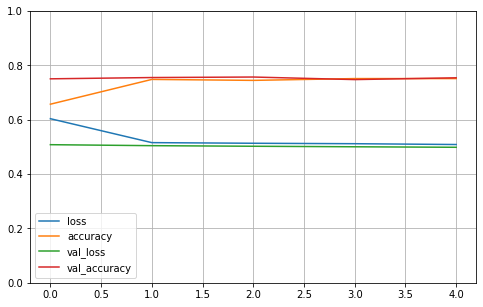

Compute valiation accuracy
2022-12-29 16:05:50.116234
Range of scores: 0.02940981 to 0.94260675
Predicted zeros and ones 539 523
Accuracy: 75.42% Precision: 70.75% Recall: 77.41% F1: 73.93%
2022-12-29 16:05:50.313904
Fold 5
Training example
[ 34 135  26 ...   0   0   0]
Train sizes (4496, 3997) (4496, 1)
Valid sizes (1083, 3997) (1083, 1)
Train set ones/size 1980 / 4496
Valid set ones/size 486 / 1083
BUILD MODEL
COMPILE
FIT
2022-12-29 16:05:52.111938
Epoch 1/5
141/141 [==============================] - 2s 9ms/step - loss: 0.5942 - accuracy: 0.6610 - val_loss: 0.5057 - val_accuracy: 0.7701
Epoch 2/5
141/141 [==============================] - 1s 7ms/step - loss: 0.5158 - accuracy: 0.7402 - val_loss: 0.5055 - val_accuracy: 0.7645
Epoch 3/5
141/141 [==============================] - 1s 7ms/step - loss: 0.5108 - accuracy: 0.7431 - val_loss: 0.5055 - val_accuracy: 0.7636
Epoch 4/5
141/141 [==============================] - 1s 7ms/step - loss: 0.5076 - accuracy: 0.7442 - val_loss: 0.5062 - va

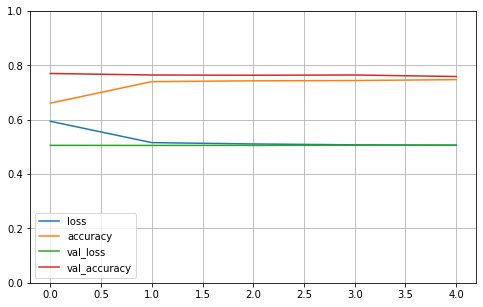

Compute valiation accuracy
2022-12-29 16:05:58.293718
Range of scores: 0.015368473 to 0.9375406
Predicted zeros and ones 604 479
Accuracy: 75.90% Precision: 73.49% Recall: 72.43% F1: 72.95%
2022-12-29 16:05:58.541688

Cross validation 5 folds 5 epochs
 accuracy mean 74.37% +/- 1.16
 precision mean 70.63% +/- 3.06
 recall mean 72.33% +/- 3.92
 F1 mean 71.34% +/- 1.96
2022-12-29 16:05:58.544317


In [152]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())